In [3]:
!pip install catboost

In [4]:
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor, HuberRegressor, TheilSenRegressor, RANSACRegressor, PassiveAggressiveRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, StackingRegressor, VotingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings

warnings.filterwarnings('ignore')

In [5]:
# Mount Google Drive
drive.mount('/content/drive')

# Set the working directory
save_folder = '/content/drive/My Drive/Task5/models/'
os.makedirs(save_folder, exist_ok=True)  # Create folder if it doesn’t exist
os.chdir(save_folder)  # Change working directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# List all files in the directory and filter for .pkl files
pkl_files = [f for f in os.listdir(save_folder) if f.endswith('.pkl')]

# Display the .pkl files
print("=== .pkl Files in Directory ===")
for file in pkl_files:
    print(file)

=== .pkl Files in Directory ===
Linear_Regression.pkl
Ridge_Regression.pkl
Lasso_Regression.pkl
Elastic_Net.pkl
Bayesian_Ridge.pkl
SGD_Regressor.pkl
Decision_Tree.pkl
KNN_Regressor.pkl
Random_Forest.pkl
Extra_Trees.pkl
Gradient_Boosting.pkl
AdaBoost.pkl
Bagging.pkl
XGBoost.pkl
LightGBM.pkl
CatBoost.pkl
MLP_Regressor.pkl
Huber_Regressor.pkl
RANSAC_Regressor.pkl
Passive_Aggressive_Regressor.pkl
Hist_Gradient_Boosting.pkl


In [6]:
data = pd.read_csv('./final_internship_data.csv')
data.head()

User ID          User Name       Driver Name Car Condition Weather  \
0  KHVrEVlD     Kimberly Adams        Amy Butler     Very Good   windy   
1  lPxIuEri       Justin Tapia  Hannah Zimmerman     Excellent  cloudy   
2  gsVN8JLS    Elizabeth Lopez    Amanda Jackson           Bad  stormy   
3  9I7kWFgd      Steven Wilson          Amy Horn     Very Good  stormy   
4  8QN5ZaGN  Alexander Andrews  Cassandra Larson           Bad  stormy   

   Traffic Condition                            key  fare_amount  \
0  Congested Traffic    2009-06-15 17:26:21.0000001          4.5   
1       Flow Traffic    2010-01-05 16:52:16.0000002         16.9   
2  Congested Traffic   2011-08-18 00:35:00.00000049          5.7   
3       Flow Traffic    2012-04-21 04:30:42.0000001          7.7   
4  Congested Traffic  2010-03-09 07:51:00.000000135          5.3   

       pickup_datetime  pickup_longitude  ...  month  weekday  year  \
0  2009-06-15 17:26:21         -1.288826  ...      6        0  2009   
1  2010-01-05 16:52:16         -1.291824  ...      1        1  2010   
2  2011-08-18 00:35:00         -1.291242  ...      8        3  2011   
3  2012-04-21 04:30:42         -1.291319  ...      4        5  2012   
4  2010-03-09 07:51:00         -1.290987  ...      3        1  2010   

    jfk_dist   ewr_dist   lga_dist   sol_dist   nyc_dist  distance   bearing  
0  20.265840  55.176046  14.342611  34.543548  27.572573  1.030764 -2.918897  
1  44.667679  31.832358  23.130775  15.125872   8.755732  8.450134 -0.375217  
2  43.597686  33.712082  19.865289  17.722624   9.847344  1.389525  2.599961  
3  42.642965  32.556289  21.063132  15.738963   7.703421  2.799270  0.133905  
4  43.329953  39.406828  15.219339  23.732406  15.600745  1.999157 -0.502703  

[5 rows x 26 columns]

In [7]:
data = data.dropna()
data.shape

(499995, 26)

In [8]:
data.duplicated().sum()

0

In [9]:
# Function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [10]:
# Dictionary to store outliers before removing them
outliers_dict = {}
cols = ['fare_amount', 'distance', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 'bearing']

# Iterate over all numerical columns
for column in cols:
    # Detect outliers
    outliers = detect_outliers_iqr(data, column)
    outliers_dict[column] = outliers  # Store detected outliers

    # Remove outliers from the original data
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only values within the valid range
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Print detected outliers
for column, outliers in outliers_dict.items():
    print(f"Number of outliers in {column} : {len(outliers)}")
data.shape

Number of outliers in fare_amount : 43329
Number of outliers in distance : 20365
Number of outliers in jfk_dist : 34959
Number of outliers in ewr_dist : 1075
Number of outliers in lga_dist : 582
Number of outliers in sol_dist : 0
Number of outliers in nyc_dist : 2
Number of outliers in bearing : 0


(399683, 26)

In [11]:
# Drop the specified columns
data = data.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'User ID', 'User Name', 'Driver Name', 'key', 'pickup_datetime'])

In [12]:
# One-hot encode the specified columns
data = pd.get_dummies(data, columns=['Traffic Condition', 'Car Condition', 'Weather'],
                      prefix=['traffic', 'car', 'weather'], drop_first=False)

# Identify the new one-hot encoded columns
traffic_cols = [col for col in data.columns if col.startswith('traffic_')]
car_cols = [col for col in data.columns if col.startswith('car_')]
weather_cols = [col for col in data.columns if col.startswith('weather_')]

# Convert the one-hot encoded columns to integers
data[traffic_cols] = data[traffic_cols].astype(int)
data[car_cols] = data[car_cols].astype(int)
data[weather_cols] = data[weather_cols].astype(int)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399683 entries, 2 to 499999
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   fare_amount                399683 non-null  float64
 1   passenger_count            399683 non-null  int64  
 2   hour                       399683 non-null  int64  
 3   day                        399683 non-null  int64  
 4   month                      399683 non-null  int64  
 5   weekday                    399683 non-null  int64  
 6   year                       399683 non-null  int64  
 7   jfk_dist                   399683 non-null  float64
 8   ewr_dist                   399683 non-null  float64
 9   lga_dist                   399683 non-null  float64
 10  sol_dist                   399683 non-null  float64
 11  nyc_dist                   399683 non-null  float64
 12  distance                   399683 non-null  float64
 13  bearing                    399683 

In [13]:
y = data['fare_amount']
x = data.drop(columns=['fare_amount'])

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [15]:
# Initialize scalers
scaler_standard = StandardScaler()   # Standardization (Z-score)

# Apply scaling
x_train = scaler_standard.fit_transform(x_train)
x_test = scaler_standard.transform(x_test)

In [16]:
# Categorize models
models_1 = [  # Linear Regression Models
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge()),
    ("Lasso Regression", Lasso()),
    ("Elastic Net", ElasticNet()),
    ("Bayesian Ridge", BayesianRidge()),
    ("SGD Regressor", SGDRegressor(max_iter=1000)),
    ("Huber Regressor", HuberRegressor()),
    ("RANSAC Regressor", RANSACRegressor()),
    ("Passive Aggressive Regressor", PassiveAggressiveRegressor(max_iter=1000))
]

models_2 = [  # Tree-Based Models
    ("Decision Tree", DecisionTreeRegressor())
]

models_3 = [  # Ensemble Learning Models
    ("Random Forest", RandomForestRegressor(n_estimators=100)),
    ("Extra Trees", ExtraTreesRegressor(n_estimators=100)),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100)),
    ("AdaBoost", AdaBoostRegressor(n_estimators=100)),
    ("Bagging", BaggingRegressor(n_estimators=10)),
    ("XGBoost", XGBRegressor(n_estimators=100, objective='reg:squarederror')),
    ("LightGBM", LGBMRegressor(n_estimators=100)),
    ("CatBoost", CatBoostRegressor(n_estimators=100, verbose=0)),
    ("Hist Gradient Boosting", HistGradientBoostingRegressor())
]

models_4 = [  # Distance-Based Models
    ("KNN Regressor", KNeighborsRegressor())
]

models_7 = [  # Neural Network Models
    ("MLP Regressor", MLPRegressor(max_iter=100))
]

# List of all model categories
all_model_groups = [
    ("Linear Regression Models", models_1),
    ("Tree-Based Models", models_2),
    ("Ensemble Learning Models", models_3),
    ("Distance-Based Models", models_4),
    ("Neural Network Models", models_7)
]

In [17]:
# Dictionary to store training times
training_times = {}

# Train and save models
for group_name, model_group in all_model_groups:
    print(f"\n=== Training {group_name} ===")
    trained_models = {}  # Store trained models for this group

    for name, model in model_group:
        print(f"Training {name}...")
        start_time = time.time()

        model.fit(x_train, y_train)  # Original data for other models

        end_time = time.time()
        elapsed_time = end_time - start_time
        training_times[name] = elapsed_time

        print(f"{name} completed in {elapsed_time:.4f} seconds")

        # Save individual model as .pkl
        individual_filename = f"{name.replace(' ', '_')}.pkl"
        with open(individual_filename, 'wb') as f:
            pickle.dump(model, f)
        print(f"Saved {name} to {individual_filename}")

        # Store trained model for group save
        trained_models[name] = model

Saved plot to /content/drive/My Drive/Task5/models/training_time_per_model.png


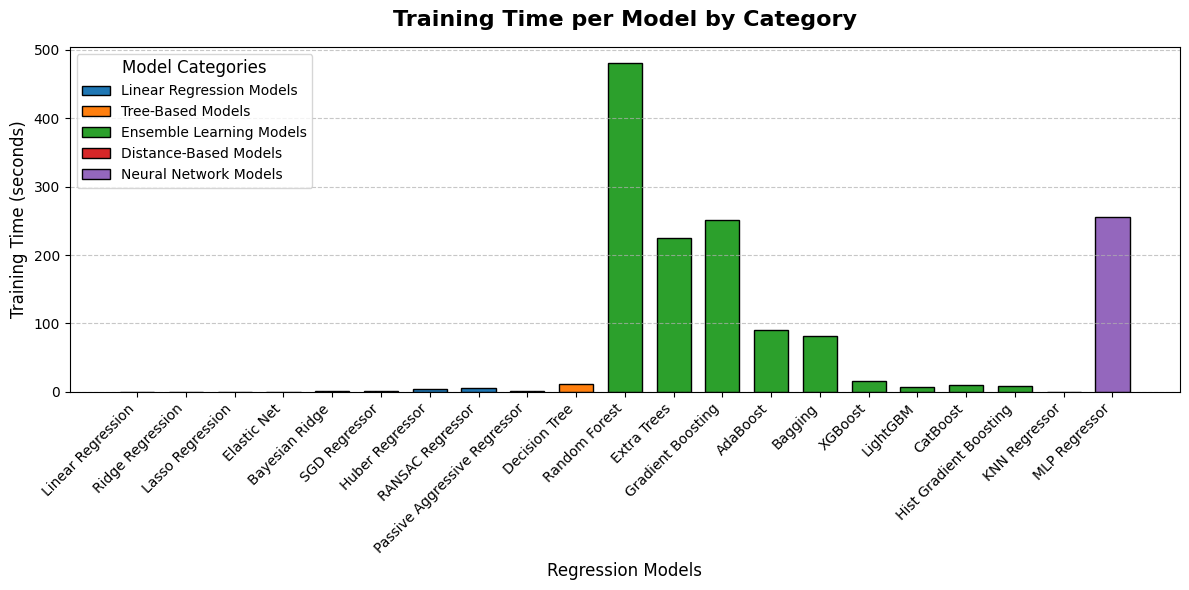

In [4]:
# Data extracted from your training output
training_times = {
    # Linear Regression Models
    "Linear Regression": 0.3232,
    "Ridge Regression": 0.1047,
    "Lasso Regression": 0.1189,
    "Elastic Net": 0.1142,
    "Bayesian Ridge": 0.5755,
    "SGD Regressor": 1.0040,
    "Huber Regressor": 4.0250,
    "RANSAC Regressor": 5.5119,
    "Passive Aggressive Regressor": 1.0645,
    # Tree-Based Models
    "Decision Tree": 11.9054,
    # Ensemble Learning Models
    "Random Forest": 480.4278,
    "Extra Trees": 224.8152,
    "Gradient Boosting": 251.7250,
    "AdaBoost": 90.6991,
    "Bagging": 81.4856,
    "XGBoost": 15.9705,
    "LightGBM": 7.7535,
    "CatBoost": 10.4252,
    "Hist Gradient Boosting": 8.1701,
    # Distance-Based Models
    "KNN Regressor": 0.0299,
    # Neural Network Models
    "MLP Regressor": 255.5540
}

# Categorize models
categories = {
    "Linear Regression Models": [
        "Linear Regression", "Ridge Regression", "Lasso Regression", "Elastic Net",
        "Bayesian Ridge", "SGD Regressor", "Huber Regressor", "RANSAC Regressor",
        "Passive Aggressive Regressor"
    ],
    "Tree-Based Models": ["Decision Tree"],
    "Ensemble Learning Models": [
        "Random Forest", "Extra Trees", "Gradient Boosting", "AdaBoost", "Bagging",
        "XGBoost", "LightGBM", "CatBoost", "Hist Gradient Boosting"
    ],
    "Distance-Based Models": ["KNN Regressor"],
    "Neural Network Models": ["MLP Regressor"]
}

# Colors for each category (professional palette)
category_colors = {
    "Linear Regression Models": "#1f77b4",      # Blue
    "Tree-Based Models": "#ff7f0e",            # Orange
    "Ensemble Learning Models": "#2ca02c",      # Green
    "Distance-Based Models": "#d62728",         # Red
    "Neural Network Models": "#9467bd"          # Purple
}

# Prepare data for plotting
models = []
times = []
colors = []

for category, model_list in categories.items():
    for model in model_list:
        if model in training_times:  # Ensure model exists in data
            models.append(model)
            times.append(training_times[model])
            colors.append(category_colors[category])

# Create the bar plot
plt.figure(figsize=(12, 6))  # Wide figure for readability in slides
bars = plt.bar(models, times, color=colors, edgecolor='black', width=0.7)

# Customize the plot
plt.title("Training Time per Model by Category", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Regression Models", fontsize=12)
plt.ylabel("Training Time (seconds)", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for readability
plt.tight_layout()

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor='black', label=cat)
                   for cat, color in category_colors.items()]
plt.legend(handles=legend_elements, title="Model Categories",
           loc='upper left', fontsize=10, title_fontsize=12)

# Save the plot
plot_filename = f"{save_folder}training_time_per_model.png"
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')  # High DPI for presentation
print(f"Saved plot to {plot_filename}")

# Display the plot
plt.show()

In [ ]:
# List of trained model filenames (remove .pkl extension for consistency with earlier naming)
model_names = [
    "AdaBoost", "Decision_Tree", "KNN_Regressor", "Random_Forest",
    "Bagging", "Elastic_Net", "Lasso_Regression", "Ridge_Regression",
    "Bayesian_Ridge", "Extra_Trees", "LightGBM", "SGD_Regressor",
    "CatBoost", "Gradient_Boosting", "MLP_Regressor", "Linear_Regression",
    "XGBoost", "Huber_Regressor", "RANSAC_Regressor", "Passive_Aggressive_Regressor",
    "Hist_Gradient_Boosting"
]

Evaluating AdaBoost...


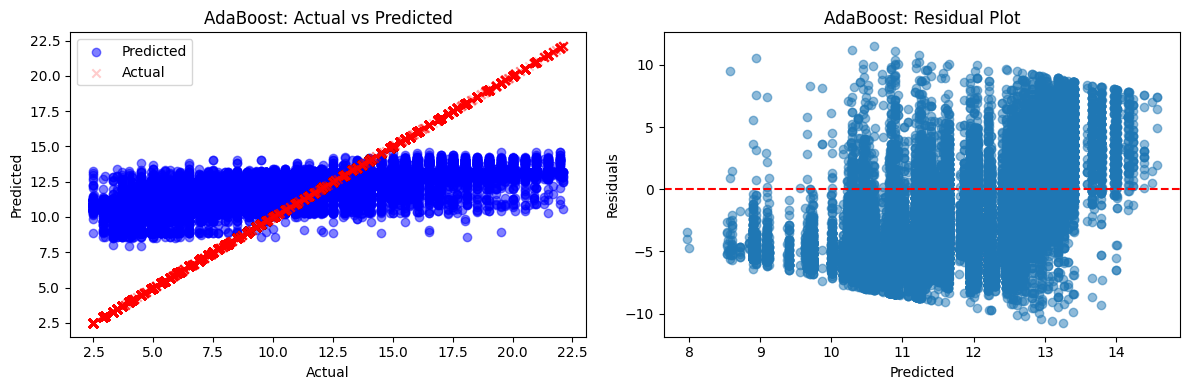

Saved plot to /content/drive/My Drive/Task5/models/AdaBoost_evaluation_plot.png
Evaluating Decision_Tree...


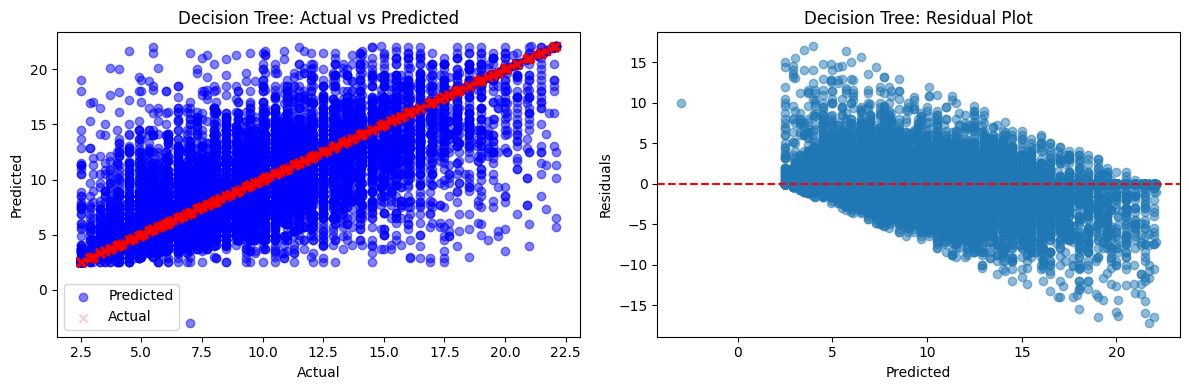

Saved plot to /content/drive/My Drive/Task5/models/Decision_Tree_evaluation_plot.png
Evaluating KNN_Regressor...


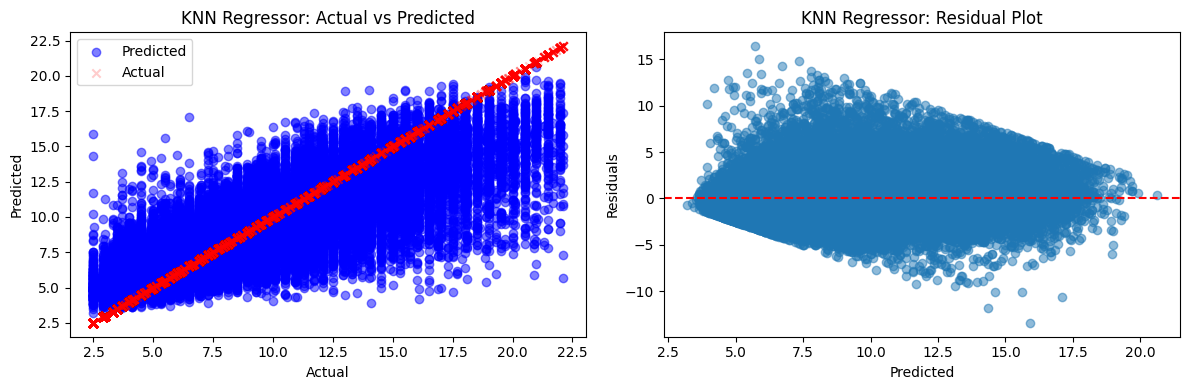

Saved plot to /content/drive/My Drive/Task5/models/KNN_Regressor_evaluation_plot.png
Evaluating Random_Forest...


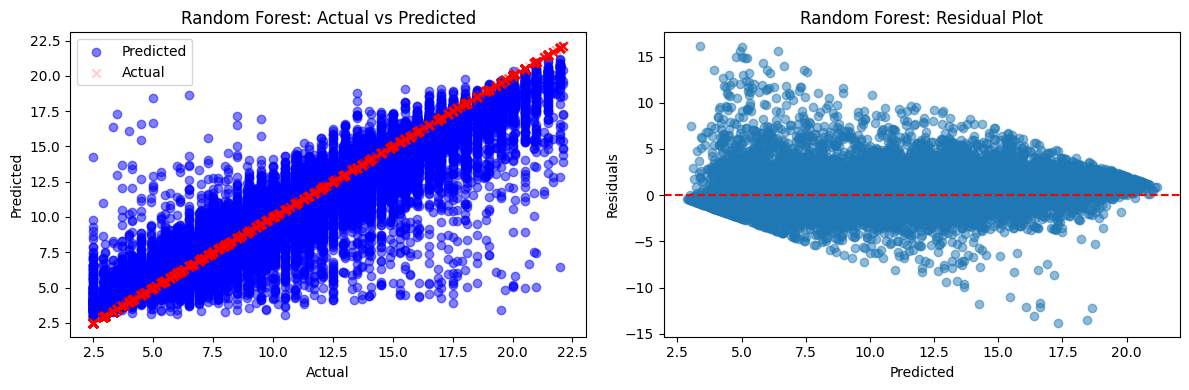

Saved plot to /content/drive/My Drive/Task5/models/Random_Forest_evaluation_plot.png
Evaluating Bagging...


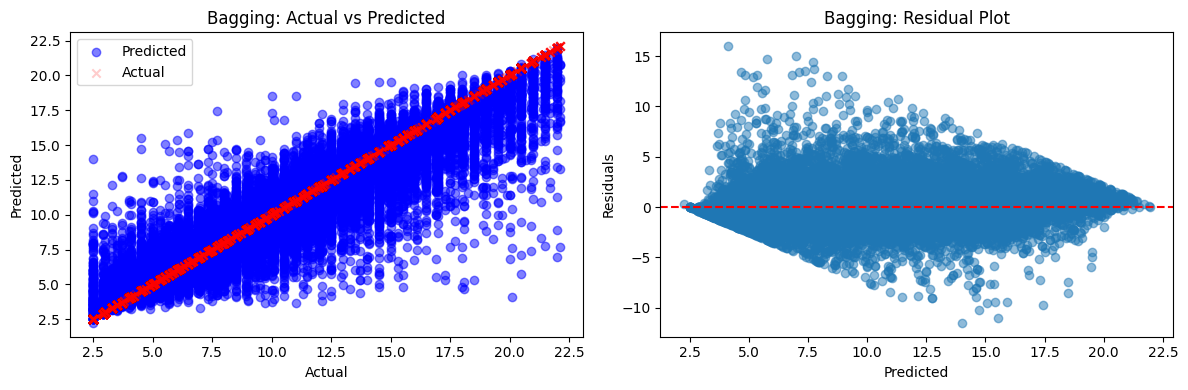

Saved plot to /content/drive/My Drive/Task5/models/Bagging_evaluation_plot.png
Evaluating Elastic_Net...


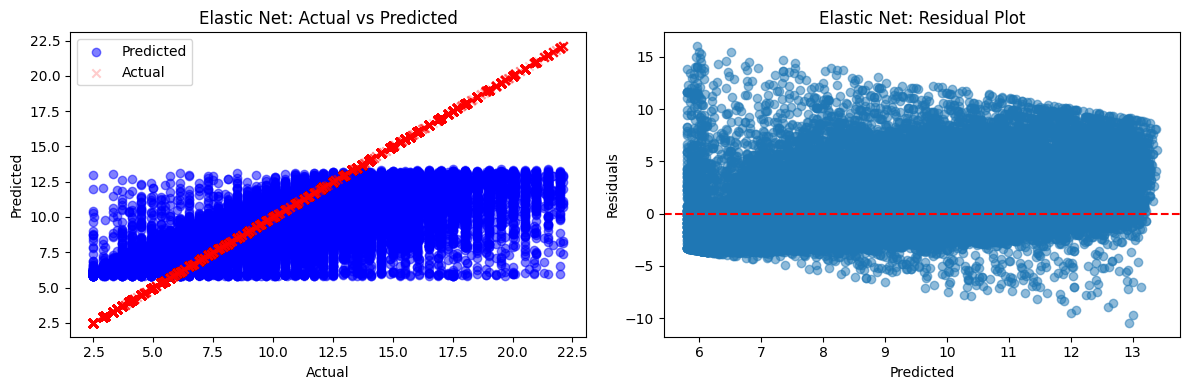

Saved plot to /content/drive/My Drive/Task5/models/Elastic_Net_evaluation_plot.png
Evaluating Lasso_Regression...


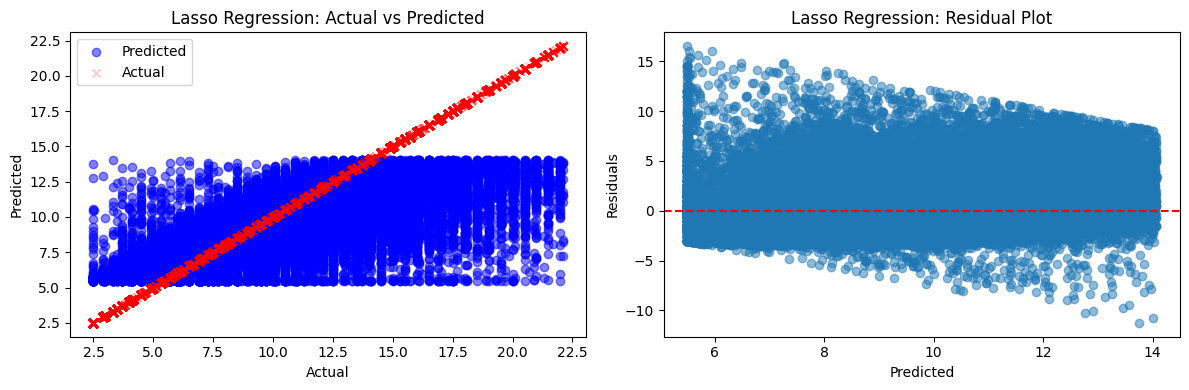

Saved plot to /content/drive/My Drive/Task5/models/Lasso_Regression_evaluation_plot.png
Evaluating Ridge_Regression...


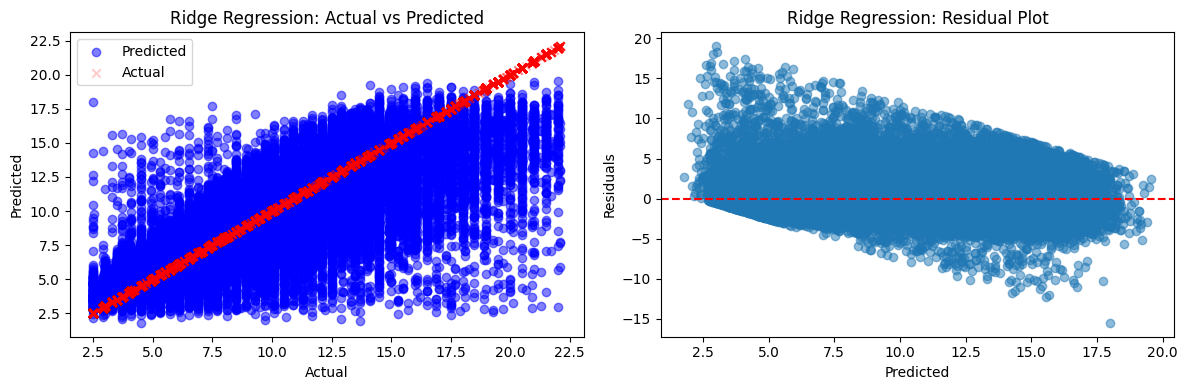

Saved plot to /content/drive/My Drive/Task5/models/Ridge_Regression_evaluation_plot.png
Evaluating Bayesian_Ridge...


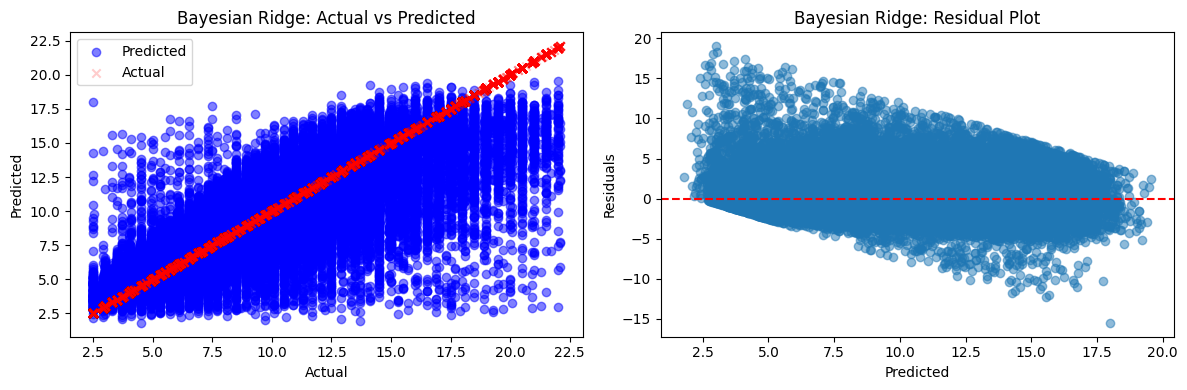

Saved plot to /content/drive/My Drive/Task5/models/Bayesian_Ridge_evaluation_plot.png
Evaluating Extra_Trees...


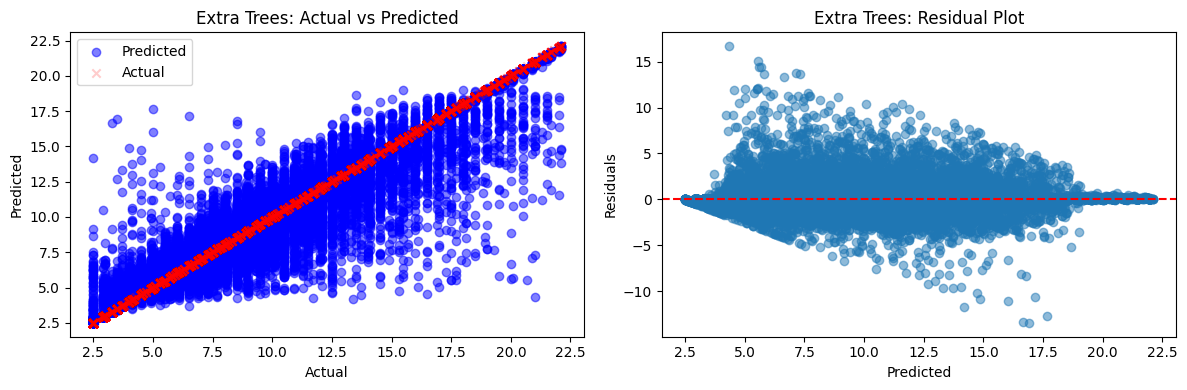

Saved plot to /content/drive/My Drive/Task5/models/Extra_Trees_evaluation_plot.png
Evaluating LightGBM...


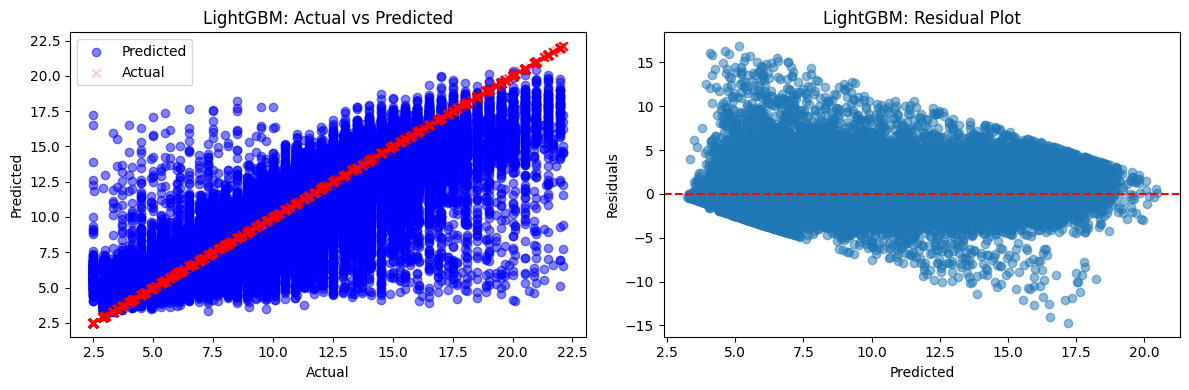

Saved plot to /content/drive/My Drive/Task5/models/LightGBM_evaluation_plot.png
Evaluating SGD_Regressor...


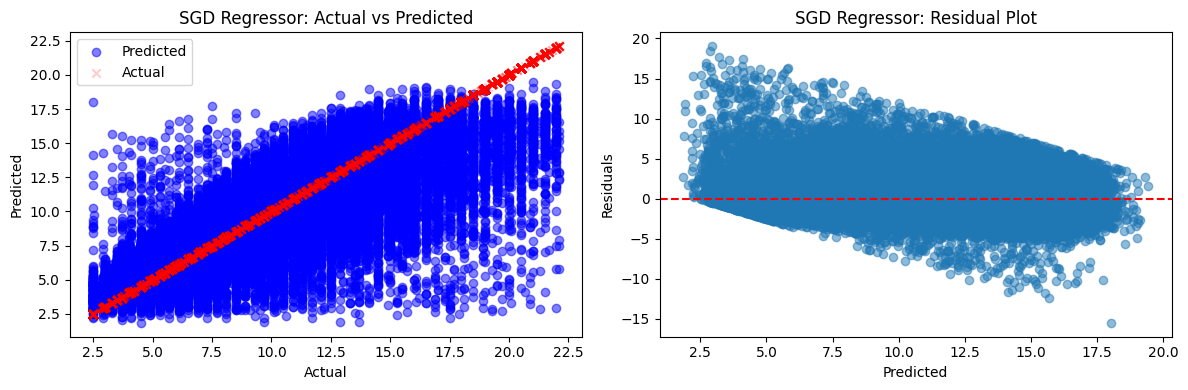

Saved plot to /content/drive/My Drive/Task5/models/SGD_Regressor_evaluation_plot.png
Evaluating CatBoost...


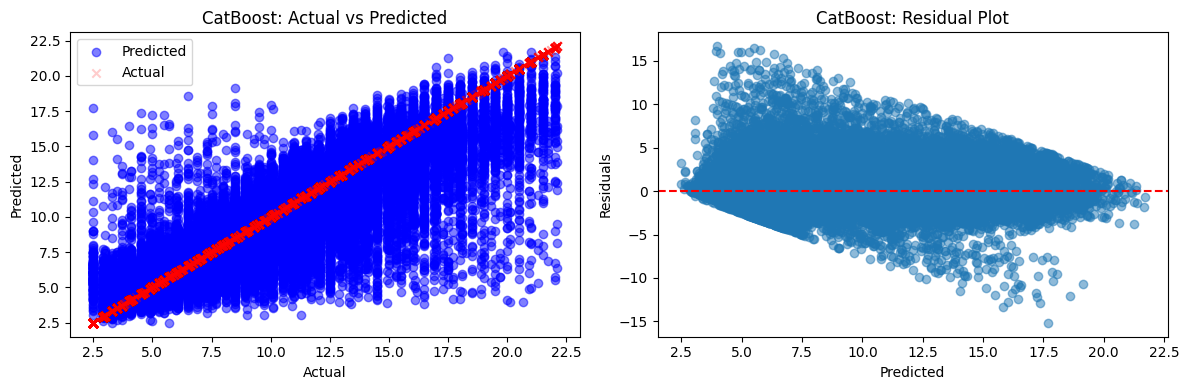

Saved plot to /content/drive/My Drive/Task5/models/CatBoost_evaluation_plot.png
Evaluating Gradient_Boosting...


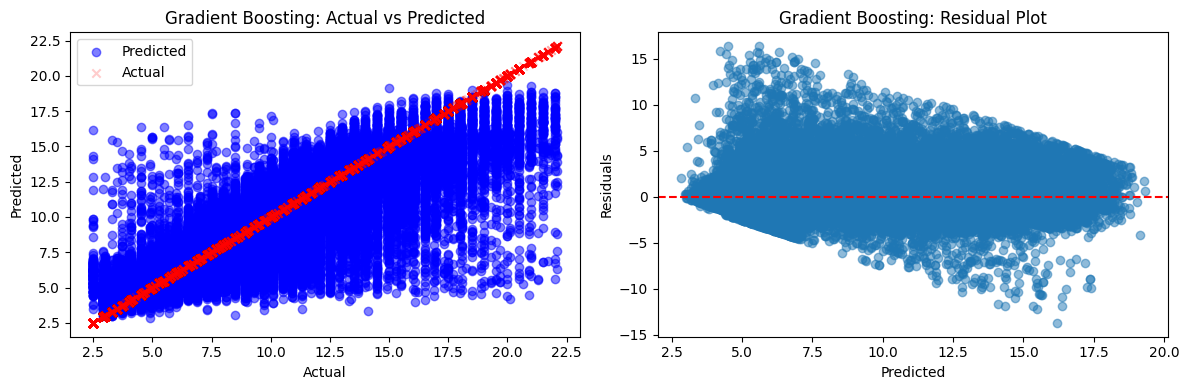

Saved plot to /content/drive/My Drive/Task5/models/Gradient_Boosting_evaluation_plot.png
Evaluating MLP_Regressor...


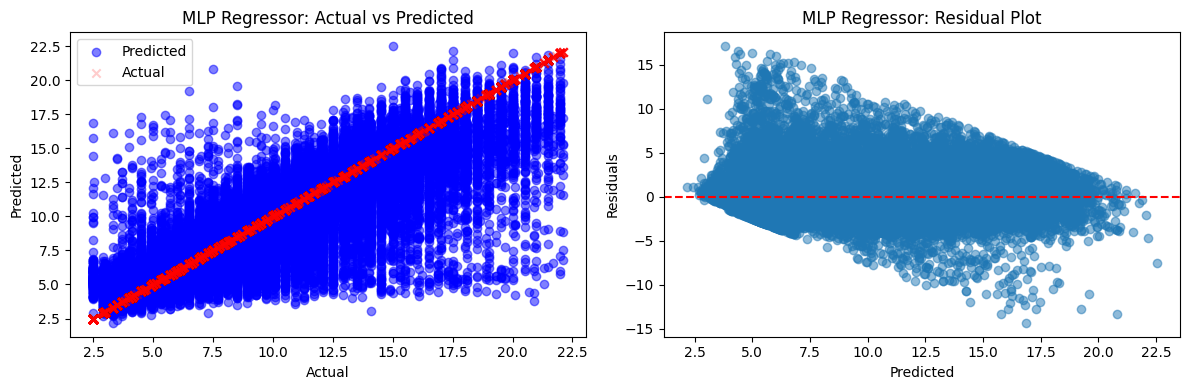

Saved plot to /content/drive/My Drive/Task5/models/MLP_Regressor_evaluation_plot.png
Evaluating Linear_Regression...


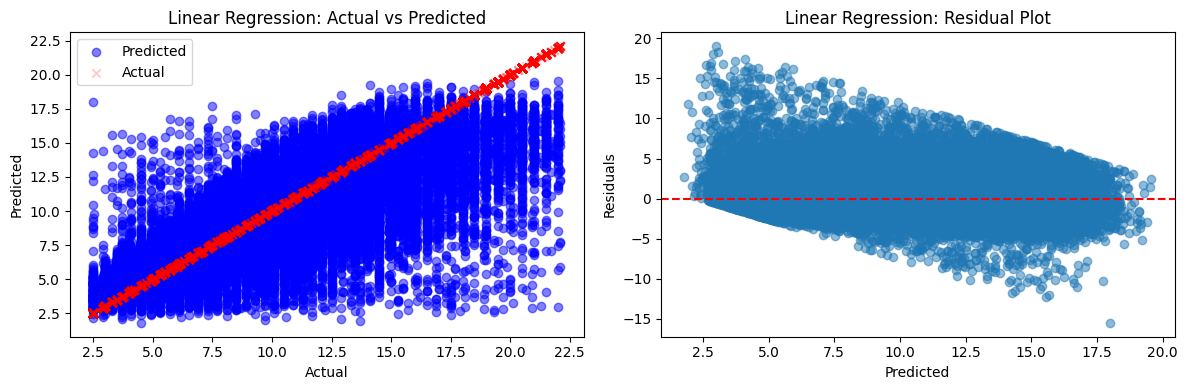

Saved plot to /content/drive/My Drive/Task5/models/Linear_Regression_evaluation_plot.png
Evaluating XGBoost...


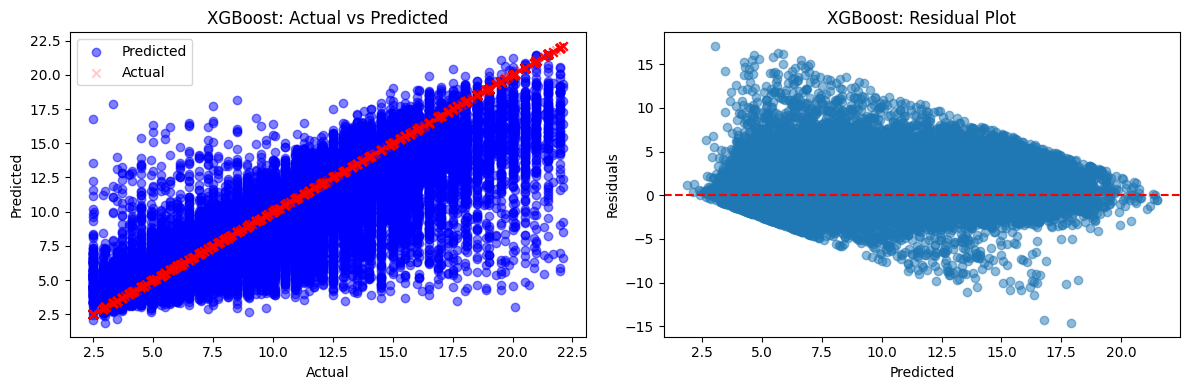

Saved plot to /content/drive/My Drive/Task5/models/XGBoost_evaluation_plot.png
Evaluating Huber_Regressor...


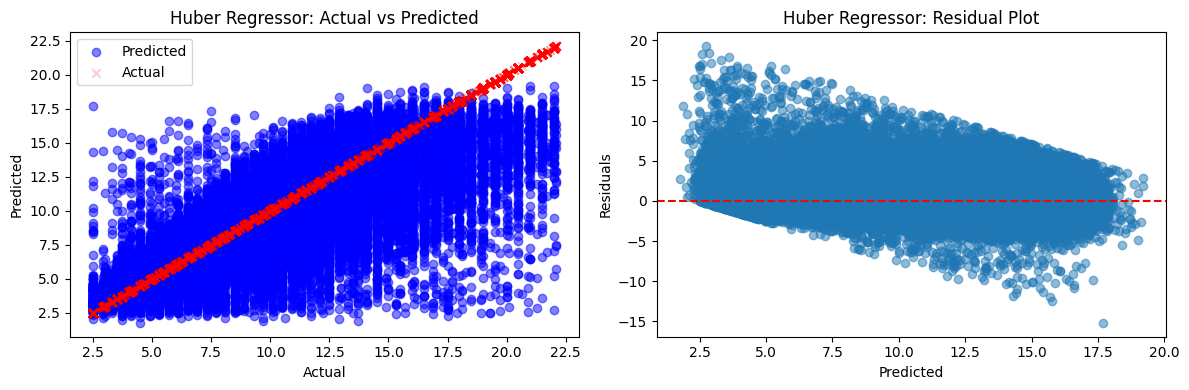

Saved plot to /content/drive/My Drive/Task5/models/Huber_Regressor_evaluation_plot.png
Evaluating RANSAC_Regressor...


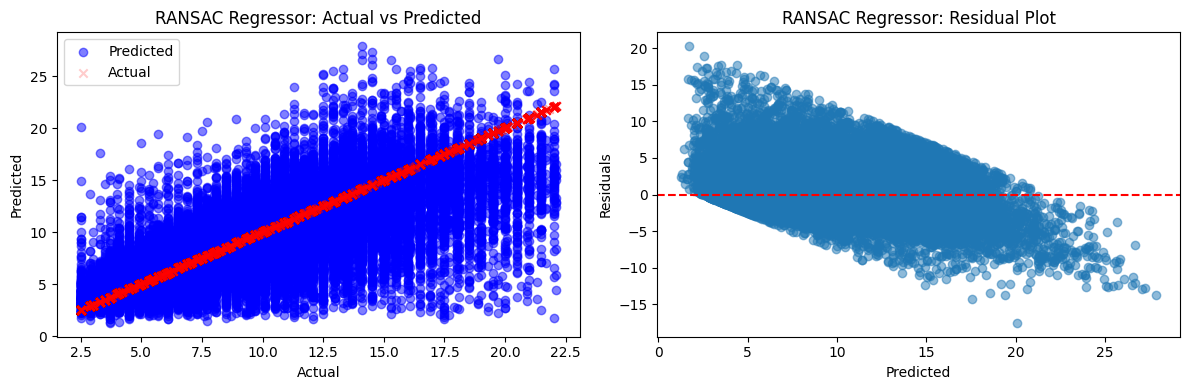

Saved plot to /content/drive/My Drive/Task5/models/RANSAC_Regressor_evaluation_plot.png
Evaluating Passive_Aggressive_Regressor...


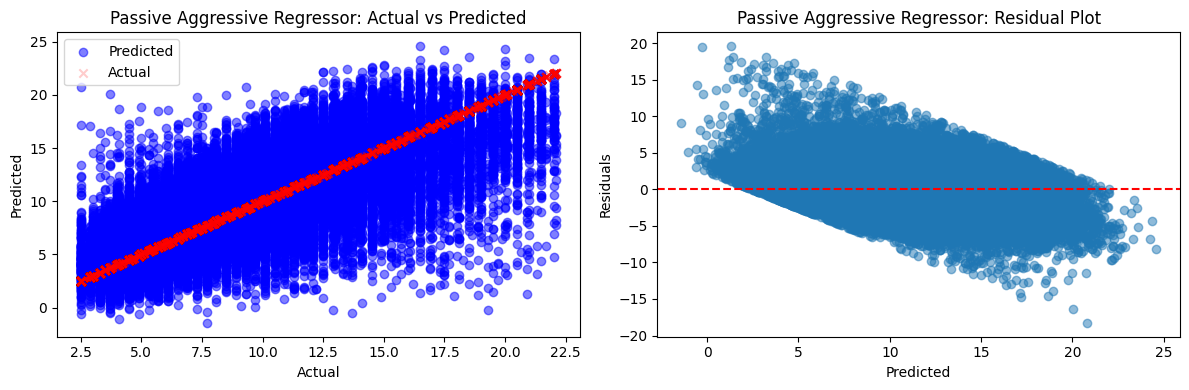

Saved plot to /content/drive/My Drive/Task5/models/Passive_Aggressive_Regressor_evaluation_plot.png
Evaluating Hist_Gradient_Boosting...


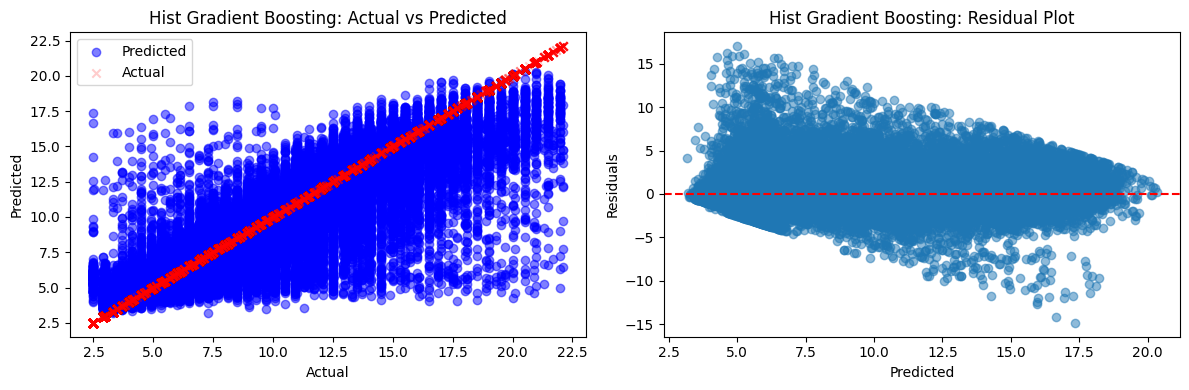

Saved plot to /content/drive/My Drive/Task5/models/Hist_Gradient_Boosting_evaluation_plot.png


In [ ]:
# Initialize lists to store results
results = {
    "Model": [],
    "MSE": [],
    "RMSE": [],
    "MAE": [],
    "R2": [],
    "Prediction Time (s)": [],
    "Complexity": []
}

# Evaluate each model
for name in model_names:
    print(f"Evaluating {name}...")

    # Load the model from Google Drive
    filename = f"{save_folder}{name}.pkl"
    try:
        with open(filename, 'rb') as f:
            model = pickle.load(f)
    except FileNotFoundError:
        print(f"Model {name} not found at {filename}. Skipping...")
        continue

    # Measure prediction time
    start_time = time.time()
    y_pred = model.predict(x_test)
    end_time = time.time()
    pred_time = end_time - start_time

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Estimate complexity (where applicable)
    complexity = "N/A"
    model_name_clean = name.replace('_', ' ')  # Use the exact name from model_names

    if hasattr(model, 'coef_'):  # Linear models
        complexity = len(model.coef_)
    elif hasattr(model, 'tree_'):  # Decision Tree
        complexity = model.tree_.node_count
    elif hasattr(model, 'estimators_'):  # Ensemble models
        # Handle tree-based ensembles
        if model_name_clean in ["Random Forest", "Extra Trees", "Gradient Boosting", "Bagging", "AdaBoost"]:
            if all(hasattr(est, 'tree_') for est in model.estimators_):
                complexity = sum(est.tree_.node_count for est in model.estimators_)
            else:
                complexity = len(model.estimators_)

    # Append results with the exact model name from the .pkl file
    results["Model"].append(model_name_clean)
    results["MSE"].append(mse)
    results["RMSE"].append(rmse)
    results["MAE"].append(mae)
    results["R2"].append(r2)
    results["Prediction Time (s)"].append(pred_time)
    results["Complexity"].append(complexity)

    # --- Plotting ---
    plt.figure(figsize=(12, 4))

    # 1. Actual vs Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted', marker='o')  # Predicted points in blue circles
    plt.scatter(y_test, y_test, color='red', alpha=0.2, label='Actual', marker='x')     # Actual points in red x’s (on diagonal)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)   # Diagonal line
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name_clean}: Actual vs Predicted")
    plt.legend()  # Add legend to distinguish

    # 2. Residual Plot
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"{model_name_clean}: Residual Plot")

    plt.tight_layout()
    plot_filename = f"{save_folder}{name}_evaluation_plot.png"
    plt.savefig(plot_filename)
    plt.show()
    print(f"Saved plot to {plot_filename}")

# Create DataFrame from results
results_df = pd.DataFrame(results)

In [ ]:
# Display results
print("\n=== Evaluation Results ===")
# Sort by R² (descending order: best to worst)
results_df_sorted = results_df.sort_values(by="R2", ascending=False)

# Display sorted results
print("\n=== Sorted Evaluation Results (by R², Best to Worst) ===")
results_df_sorted


=== Evaluation Results ===

=== Sorted Evaluation Results (by R², Best to Worst) ===


Model        MSE      RMSE       MAE        R2  \
9                    Extra Trees   0.694553  0.833399  0.275959  0.946967   
3                  Random Forest   1.162527  1.078205  0.631468  0.911235   
4                        Bagging   1.303234  1.141593  0.701355  0.900491   
1                  Decision Tree   1.712647  1.308681  0.432183  0.869230   
12                      CatBoost   2.904908  1.704379  1.126383  0.778195   
10                      LightGBM   2.939821  1.714591  1.132575  0.775529   
20        Hist Gradient Boosting   2.949464  1.717400  1.131076  0.774793   
14                 MLP Regressor   3.208050  1.791103  1.209663  0.755048   
16                       XGBoost   3.220066  1.794454  1.162049  0.754131   
13             Gradient Boosting   3.418106  1.848812  1.255478  0.739010   
2                  KNN Regressor   4.148621  2.036816  1.496715  0.683231   
8                 Bayesian Ridge   4.504609  2.122406  1.502063  0.656049   
7               Ridge Regression   4.504609  2.122406  1.502064  0.656049   
15             Linear Regression   4.504610  2.122407  1.502064  0.656049   
11                 SGD Regressor   4.516574  2.125223  1.503627  0.655136   
17               Huber Regressor   4.610921  2.147305  1.462423  0.647932   
18              RANSAC Regressor   5.856432  2.420007  1.707842  0.552830   
6               Lasso Regression   6.019953  2.453559  1.846480  0.540345   
5                    Elastic Net   6.545440  2.558406  1.945879  0.500221   
19  Passive Aggressive Regressor   7.347170  2.710566  2.109786  0.439005   
0                       AdaBoost  19.148677  4.375920  3.903221 -0.462103   

    Prediction Time (s) Complexity  
9              7.267796   51753334  
3              5.746538   29047534  
4              0.666720    2906116  
1              0.062726     449565  
12             0.039770        N/A  
10             0.853011        N/A  
20             0.915089        N/A  
14             0.131519        N/A  
16             0.212184        N/A  
13             0.192304        100  
2            169.809127        N/A  
8              0.003925         25  
7              0.007944         25  
15             0.003991         25  
11             0.007294         25  
17             0.004000         25  
18             0.003642        N/A  
6              0.008934         25  
5              0.003831         25  
19             0.003532         25  
0              0.449613        780

In [ ]:
# Save sorted results to CSV in Google Drive
sorted_results_csv = f"{save_folder}regression_model_evaluation_sorted.csv"
results_df_sorted.to_csv(sorted_results_csv, index=False)
print(f"Saved sorted evaluation results to {sorted_results_csv}")

Saved sorted evaluation results to /content/drive/My Drive/Task5/models/regression_model_evaluation_sorted.csv


Saved plot to /content/drive/My Drive/Task5/models/r2_performance_per_model.png


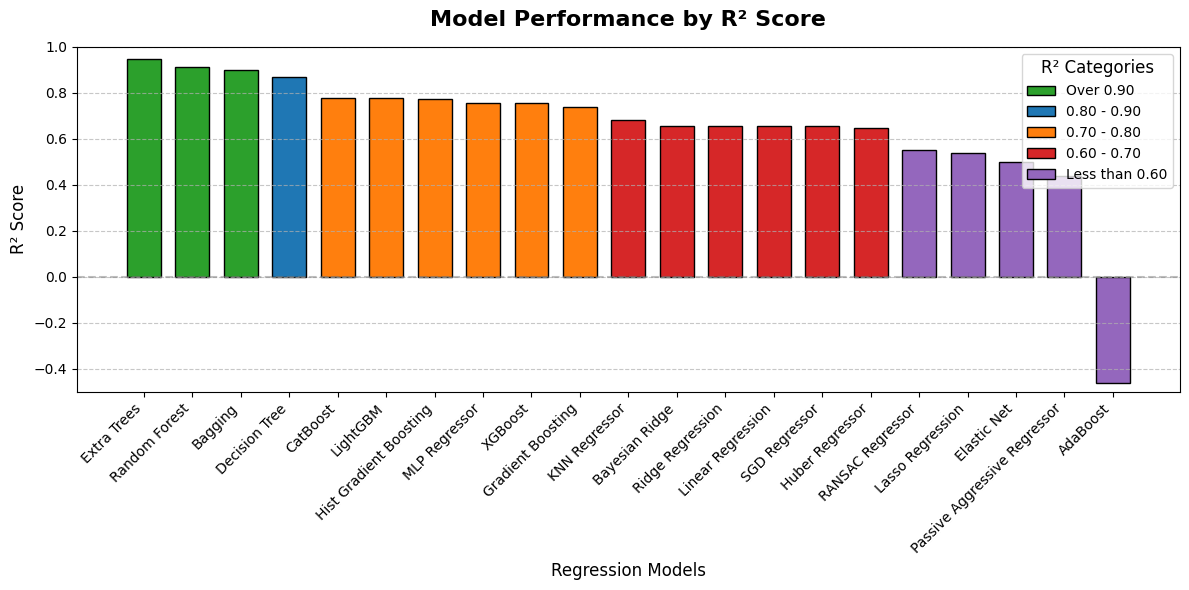

In [6]:
# Data extracted from your evaluation results (Model and R2 only)
model_r2 = {
    "Extra Trees": 0.946967159143928,
    "Random Forest": 0.9112349009584261,
    "Bagging": 0.9004911402268942,
    "Decision Tree": 0.8692303127737482,
    "CatBoost": 0.7781948962175741,
    "LightGBM": 0.7755290435548573,
    "Hist Gradient Boosting": 0.7747927531405765,
    "MLP Regressor": 0.7550483941062348,
    "XGBoost": 0.7541308948630963,
    "Gradient Boosting": 0.7390095062380699,
    "KNN Regressor": 0.6832307805548382,
    "Bayesian Ridge": 0.6560492286646081,
    "Ridge Regression": 0.6560492011459975,
    "Linear Regression": 0.6560491696244128,
    "SGD Regressor": 0.6551356097348077,
    "Huber Regressor": 0.6479317586023319,
    "RANSAC Regressor": 0.5528303546168584,
    "Lasso Regression": 0.540344695874005,
    "Elastic Net": 0.5002209282187771,
    "Passive Aggressive Regressor": 0.4390046184058176,
    "AdaBoost": -0.46210306263288903
}

# Define R² score categories
categories = {
    "Over 0.90": [],
    "0.80 - 0.90": [],
    "0.70 - 0.80": [],
    "0.60 - 0.70": [],
    "Less than 0.60": []
}

# Assign models to categories based on R²
for model, r2 in model_r2.items():
    if r2 > 0.90:
        categories["Over 0.90"].append(model)
    elif 0.80 <= r2 <= 0.90:
        categories["0.80 - 0.90"].append(model)
    elif 0.70 <= r2 < 0.80:
        categories["0.70 - 0.80"].append(model)
    elif 0.60 <= r2 < 0.70:
        categories["0.60 - 0.70"].append(model)
    else:
        categories["Less than 0.60"].append(model)

# Colors for each R² category (professional palette)
category_colors = {
    "Over 0.90": "#2ca02c",          # Green (high performance)
    "0.80 - 0.90": "#1f77b4",        # Blue
    "0.70 - 0.80": "#ff7f0e",        # Orange
    "0.60 - 0.70": "#d62728",        # Red
    "Less than 0.60": "#9467bd"      # Purple (low performance)
}

# Prepare data for plotting
models = []
r2_scores = []
colors = []

for category, model_list in categories.items():
    for model in model_list:
        models.append(model)
        r2_scores.append(model_r2[model])
        colors.append(category_colors[category])

# Create the bar plot
plt.figure(figsize=(12, 6))  # Wide figure for slide readability
bars = plt.bar(models, r2_scores, color=colors, edgecolor='black', width=0.7)

# Customize the plot
plt.title("Model Performance by R² Score", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Regression Models", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for readability
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)  # Zero line for negative R²
plt.ylim(-0.5, 1.0)  # Adjust y-axis to show negative R² (AdaBoost)
plt.tight_layout()

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor='black', label=cat)
                   for cat, color in category_colors.items()]
plt.legend(handles=legend_elements, title="R² Categories",
           loc='upper right', fontsize=10, title_fontsize=12)

# Save the plot
plot_filename = f"{save_folder}r2_performance_per_model.png"
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')  # High DPI for presentation
print(f"Saved plot to {plot_filename}")

# Display the plot
plt.show()

Saved MSE plot to /content/drive/My Drive/Task5/models/mse_performance_per_model.png


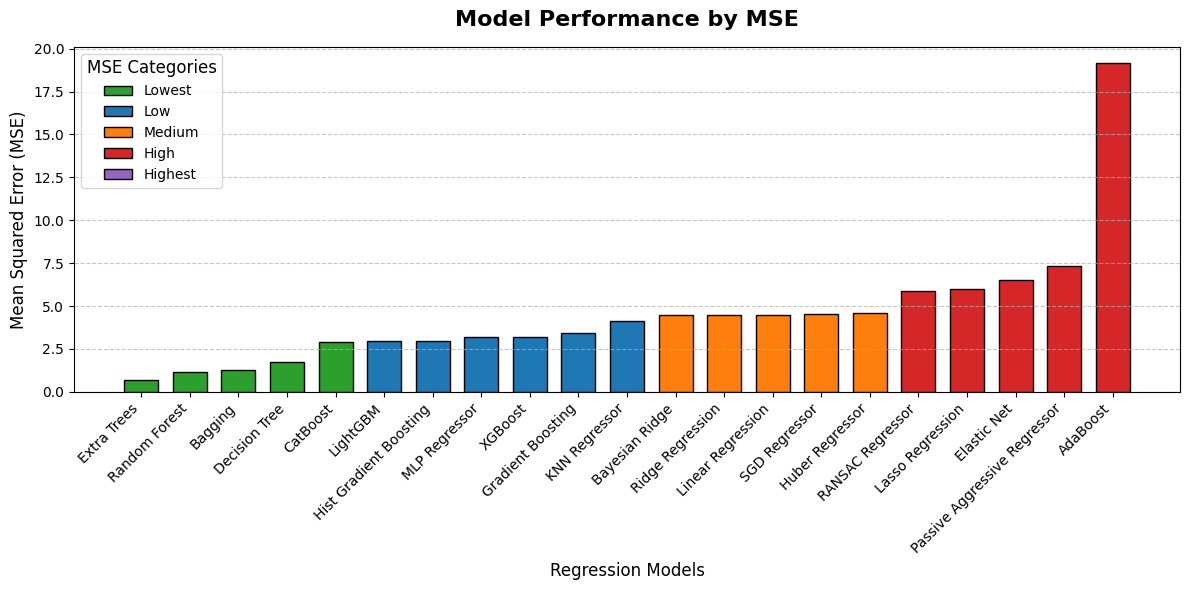

Saved RMSE plot to /content/drive/My Drive/Task5/models/rmse_performance_per_model.png


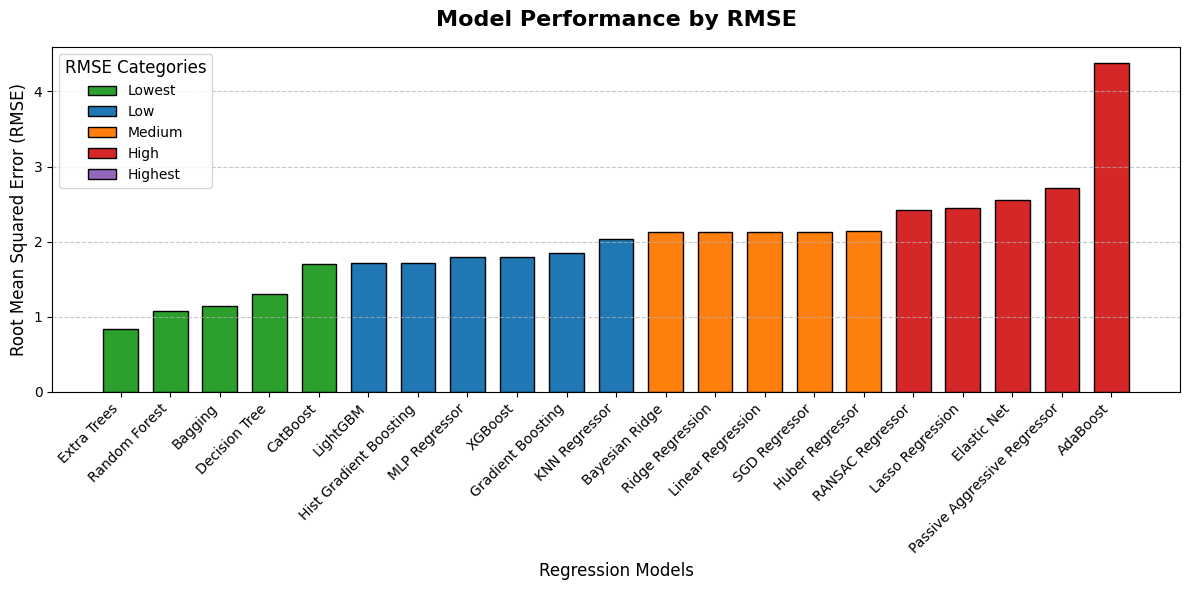

Saved MAE plot to /content/drive/My Drive/Task5/models/mae_performance_per_model.png


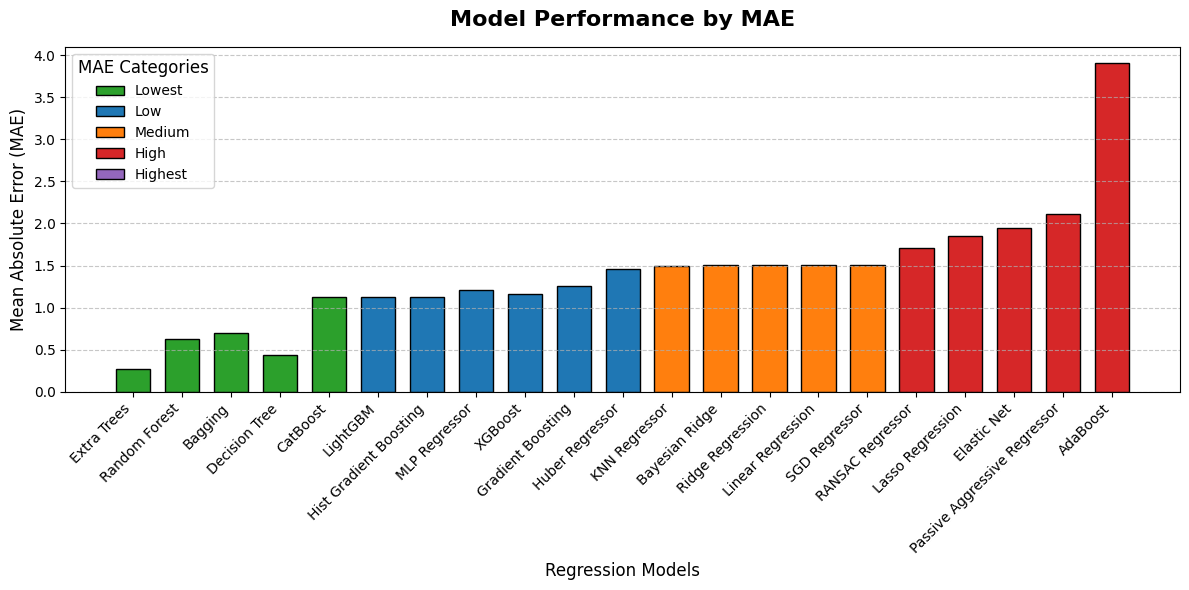

In [7]:
# Data extracted from your evaluation results
model_metrics = {
    "Extra Trees": {"MSE": 0.694553, "RMSE": 0.833399, "MAE": 0.275959},
    "Random Forest": {"MSE": 1.162527, "RMSE": 1.078205, "MAE": 0.631468},
    "Bagging": {"MSE": 1.303234, "RMSE": 1.141593, "MAE": 0.701355},
    "Decision Tree": {"MSE": 1.712647, "RMSE": 1.308681, "MAE": 0.432183},
    "CatBoost": {"MSE": 2.904908, "RMSE": 1.704379, "MAE": 1.126383},
    "LightGBM": {"MSE": 2.939821, "RMSE": 1.714591, "MAE": 1.132575},
    "Hist Gradient Boosting": {"MSE": 2.949464, "RMSE": 1.717400, "MAE": 1.131076},
    "MLP Regressor": {"MSE": 3.208050, "RMSE": 1.791103, "MAE": 1.209663},
    "XGBoost": {"MSE": 3.220066, "RMSE": 1.794454, "MAE": 1.162049},
    "Gradient Boosting": {"MSE": 3.418106, "RMSE": 1.848812, "MAE": 1.255478},
    "KNN Regressor": {"MSE": 4.148621, "RMSE": 2.036816, "MAE": 1.496715},
    "Bayesian Ridge": {"MSE": 4.504609, "RMSE": 2.122406, "MAE": 1.502063},
    "Ridge Regression": {"MSE": 4.504609, "RMSE": 2.122406, "MAE": 1.502064},
    "Linear Regression": {"MSE": 4.504610, "RMSE": 2.122407, "MAE": 1.502064},
    "SGD Regressor": {"MSE": 4.516574, "RMSE": 2.125223, "MAE": 1.503627},
    "Huber Regressor": {"MSE": 4.610921, "RMSE": 2.147305, "MAE": 1.462423},
    "RANSAC Regressor": {"MSE": 5.856432, "RMSE": 2.420007, "MAE": 1.707842},
    "Lasso Regression": {"MSE": 6.019953, "RMSE": 2.453559, "MAE": 1.846480},
    "Elastic Net": {"MSE": 6.545440, "RMSE": 2.558406, "MAE": 1.945879},
    "Passive Aggressive Regressor": {"MSE": 7.347170, "RMSE": 2.710566, "MAE": 2.109786},
    "AdaBoost": {"MSE": 19.148677, "RMSE": 4.375920, "MAE": 3.903221}
}

# Define metrics to plot
metrics = ["MSE", "RMSE", "MAE"]

# Colors for categories (professional palette, 5 bins)
category_colors = {
    "Lowest": "#2ca02c",      # Green (best performance)
    "Low": "#1f77b4",         # Blue
    "Medium": "#ff7f0e",      # Orange
    "High": "#d62728",        # Red
    "Highest": "#9467bd"      # Purple (worst performance)
}

# Function to create and save a plot for a given metric
def create_performance_plot(metric, ylabel, filename):
    # Extract values and sort models
    models = list(model_metrics.keys())
    values = [model_metrics[model][metric] for model in models]

    # Define dynamic categories based on quartiles + outlier
    sorted_values = sorted(values)
    bins = [
        sorted_values[0],              # Min
        sorted_values[4],              # ~20th percentile
        sorted_values[10],             # ~50th percentile
        sorted_values[15],             # ~75th percentile
        sorted_values[-1]              # Max
    ]
    category_labels = ["Lowest", "Low", "Medium", "High", "Highest"]

    # Assign models to categories
    categories = {label: [] for label in category_labels}
    for model, value in zip(models, values):
        if value <= bins[1]:
            categories["Lowest"].append(model)
        elif value <= bins[2]:
            categories["Low"].append(model)
        elif value <= bins[3]:
            categories["Medium"].append(model)
        elif value <= bins[4]:
            categories["High"].append(model)
        else:
            categories["Highest"].append(model)

    # Prepare data for plotting
    plot_models = []
    plot_values = []
    colors = []
    for cat in category_labels:
        for model in categories[cat]:
            plot_models.append(model)
            plot_values.append(model_metrics[model][metric])
            colors.append(category_colors[cat])

    # Create the bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(plot_models, plot_values, color=colors, edgecolor='black', width=0.7)

    # Customize the plot
    plt.title(f"Model Performance by {metric}", fontsize=16, fontweight='bold', pad=15)
    plt.xlabel("Regression Models", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=cat)
                       for cat, color in category_colors.items()]
    plt.legend(handles=legend_elements, title=f"{metric} Categories",
               loc='upper left', fontsize=10, title_fontsize=12)

    # Save the plot
    plot_filename = f"{save_folder}{filename}"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"Saved {metric} plot to {plot_filename}")

    # Display the plot
    plt.show()

# Generate plots for each metric
create_performance_plot("MSE", "Mean Squared Error (MSE)", "mse_performance_per_model.png")
create_performance_plot("RMSE", "Root Mean Squared Error (RMSE)", "rmse_performance_per_model.png")
create_performance_plot("MAE", "Mean Absolute Error (MAE)", "mae_performance_per_model.png")

In [17]:
# Define the base ExtraTreesRegressor model
base_model = ExtraTreesRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.5],
    'bootstrap': [True, False]
}

# Set up RandomizedSearchCV (CPU only)
grid_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=20,              # Number of random combinations to try
    cv=3,                   # 3-fold cross-validation
    scoring='r2',           # Optimize for R²
    n_jobs=-1,              # Use all CPU cores
    verbose=3,              # Higher verbosity for detailed fit info
    random_state=42         # Reproducibility
)

In [18]:
# Custom progress tracking with tqdm
total_fits = 20 * 3  # n_iter * cv = 60 fits
print(f"Starting Randomized Search for ExtraTreesRegressor with {total_fits} total fits...")

start_time = time.time()
with tqdm(total=total_fits, desc="Fitting Progress") as pbar:
    # Fit the grid search
    grid_search.fit(x_train, y_train)
    # tqdm won't update per fit natively, so we rely on verbose output
    # Post-fit update to ensure bar completes
    pbar.n = total_fits
    pbar.refresh()

end_time = time.time()
training_time = end_time - start_time
print(f"Randomized Search completed in {training_time:.4f} seconds")

# Get the best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("\n=== Best Model Details ===")
print(f"Best R² Score (cross-validation): {best_score:.4f}")
print("Best Hyperparameters:", best_params)

# Save the best model as a .pkl file
best_model_filename = f"{save_folder}Best_Extra_Trees.pkl"
with open(best_model_filename, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Saved best ExtraTreesRegressor model to {best_model_filename}")

Starting Randomized Search for ExtraTreesRegressor with 60 total fits...


Fitting Progress:   0%|          | 0/60 [00:00<?, ?it/s]

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Fitting Progress: 100%|██████████| 60/60 [41:52<00:00, 41.87s/it]


Randomized Search completed in 2512.0619 seconds

=== Best Model Details ===
Best R² Score (cross-validation): 0.7474
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': None, 'bootstrap': False}
Saved best ExtraTreesRegressor model to /content/drive/My Drive/Task5/models/Best_Extra_Trees.pkl


Saved to /content/drive/My Drive/Task5/models/extra_trees_hyperparameters_explained.png


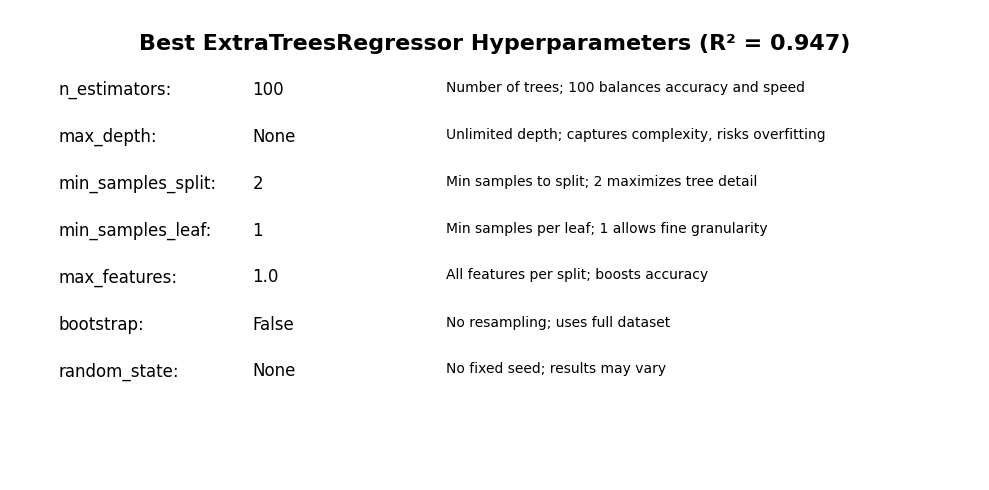

In [9]:
# Define hyperparameters with explanations
hyperparams = [
    ("n_estimators", 100, "Number of trees; 100 balances accuracy and speed"),
    ("max_depth", None, "Unlimited depth; captures complexity, risks overfitting"),
    ("min_samples_split", 2, "Min samples to split; 2 maximizes tree detail"),
    ("min_samples_leaf", 1, "Min samples per leaf; 1 allows fine granularity"),
    ("max_features", 1.0, "All features per split; boosts accuracy"),
    ("bootstrap", False, "No resampling; uses full dataset"),
    ("random_state", None, "No fixed seed; results may vary")
]

# Create figure
plt.figure(figsize=(10, 5))  # Wider for explanations
plt.axis('off')

# Title
plt.text(0.5, 0.95, "Best ExtraTreesRegressor Hyperparameters (R² = 0.947)",
         fontsize=16, fontweight='bold', ha='center', va='top')

# Display hyperparameters with explanations
y_pos = 0.85
for param, value, explanation in hyperparams:
    plt.text(0.05, y_pos, f"{param}:", fontsize=12, ha='left', va='top')
    plt.text(0.25, y_pos, str(value), fontsize=12, ha='left', va='top')
    plt.text(0.45, y_pos, explanation, fontsize=10, ha='left', va='top')
    y_pos -= 0.1

plt.tight_layout()
output_filename = f"{save_folder}extra_trees_hyperparameters_explained.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved to {output_filename}")
plt.show()

In [16]:
# Load the best Extra Trees model
model_filename = f"{save_folder}Extra_Trees.pkl"
try:
    with open(model_filename, 'rb') as f:
        best_extra_trees = pickle.load(f)
    print("Successfully loaded ExtraTreesRegressor model from", model_filename)
except FileNotFoundError:
    print(f"Error: Model file not found at {model_filename}")
    exit()

# Verify model type
if not isinstance(best_extra_trees, ExtraTreesRegressor):
    print("Error: Loaded model is not an ExtraTreesRegressor")
    exit()

Successfully loaded ExtraTreesRegressor model from /content/drive/My Drive/Task5/models/Extra_Trees.pkl


In [17]:
# Assuming x_train is your training DataFrame with feature names
# Replace with your actual feature names if different
# Example: If x_train is a DataFrame, use x_train.columns
# Define the 25 feature names based on your list
feature_names = [
    'passenger_count', 'hour', 'day', 'month', 'weekday', 'year',
    'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 'distance', 'bearing',
    'traffic_Congested Traffic', 'traffic_Dense Traffic', 'traffic_Flow Traffic',
    'car_Bad', 'car_Excellent', 'car_Good', 'car_Very Good',
    'weather_cloudy', 'weather_rainy', 'weather_stormy', 'weather_sunny', 'weather_windy'
]

# Check if feature names match the model's expected input
if len(feature_names) != best_extra_trees.n_features_in_:
    print(f"Error: Number of feature names ({len(feature_names)}) does not match model input ({best_extra_trees.n_features_in_})")
    exit()

# Get feature importances
importances = best_extra_trees.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Create a DataFrame for better handling
feature_importance_df = pd.DataFrame({
    'Feature': [feature_names[i] for i in indices],
    'Importance': importances[indices]
})

# Display feature importances in console
print("\n=== Feature Importances ===")
feature_importance_df


=== Feature Importances ===


Feature  Importance
0                    distance    0.645664
1                        year    0.053563
2                     bearing    0.038719
3                        hour    0.031395
4                    jfk_dist    0.024056
5                       month    0.020511
6                     weekday    0.018119
7                    lga_dist    0.016056
8                    nyc_dist    0.015616
9                         day    0.015108
10                   sol_dist    0.014824
11                   ewr_dist    0.014796
12            passenger_count    0.011532
13              car_Excellent    0.006809
14              car_Very Good    0.006778
15                   car_Good    0.006741
16              weather_rainy    0.006720
17             weather_cloudy    0.006719
18              weather_windy    0.006705
19             weather_stormy    0.006687
20                    car_Bad    0.006675
21      traffic_Dense Traffic    0.006645
22              weather_sunny    0.006611
23  traffic_Congested Traffic    0.006482
24       traffic_Flow Traffic    0.006472

Saved horizontal feature importance plot to /content/drive/My Drive/Task5/models/extra_trees_feature_importance_horizontal_sorted.png


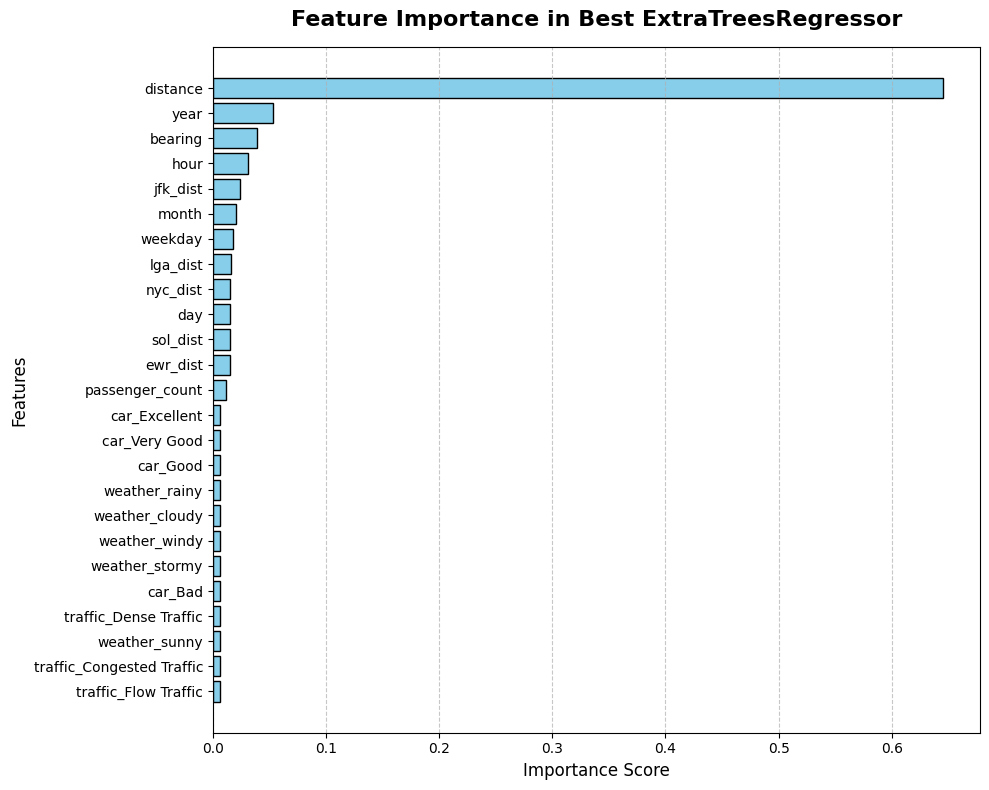

Saved feature importance data to /content/drive/My Drive/Task5/models/extra_trees_feature_importance_horizontal_sorted.csv


In [20]:
# Plot feature importances horizontally (most important at top)
plt.figure(figsize=(10, 8))  # Adjusted size for 24 features
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1],
         color='skyblue', edgecolor='black')
plt.title("Feature Importance in Best ExtraTreesRegressor", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.yticks(fontsize=10)  # No rotation needed
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save as PNG for slide
output_filename = f"{save_folder}extra_trees_feature_importance_horizontal_sorted.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved horizontal feature importance plot to {output_filename}")

# Display plot
plt.show()

# Save to CSV
csv_filename = f"{save_folder}extra_trees_feature_importance_horizontal_sorted.csv"
feature_importance_df.to_csv(csv_filename, index=False)
print(f"Saved feature importance data to {csv_filename}")